# Tutorial: Declarative Math with `MathExpressionStep`

This tutorial introduces **`MathExpressionStep`**, a Step for defining mathematical
relationships declaratively inside a Process-Bigraph simulation.

Instead of writing custom Python code, you specify equations as strings.
The Step infers its inputs, orders dependent equations correctly, and evaluates
everything in a single, instantaneous update.

The tutorial is organized around four examples that show different ways this Step
can be used.

---

## Overview

**Example 1 — A single declarative expression**
We start with the simplest case: one expression that computes a derived value
from state. This shows how input ports are inferred automatically and how outputs
are written directly into the shared state.

**Example 2 — Time-driven expressions**
Next, we introduce a minimal `Tick` process to advance time. Expressions are allowed
to depend on `t`, generating full signal trajectories without adding any additional
Processes.

**Example 3 — Multi-stage pipelines with dependencies**
We then build a small computation pipeline with intermediate variables and
nonlinear transformations. Expressions are intentionally listed out of order to
demonstrate automatic dependency resolution and topological sorting.

**Example 4 — From continuous signals to events**
Finally, we use declarative expressions to detect threshold-crossing events and
gate downstream quantities. This shows how the same Step can express arithmetic,
nonlinear transforms, and logical conditions in one place.

---

By the end of the tutorial, you will have seen how `MathExpressionStep` can be used to:

- express algebraic relationships compactly,
- generate time-dependent signals,
- build multi-stage computation pipelines,
- and extract discrete events from continuous dynamics.

These examples are intended to illustrate when a declarative Step is a good fit,
and how it can simplify models that would otherwise require custom Processes.


In [23]:
# Core scientific stack
import numpy as np

# Process-Bigraph infrastructure
from process_bigraph import allocate_core
from process_bigraph.composite import Composite
from process_bigraph.emitter import emitter_from_wires
from process_bigraph.processes.math_expression import plot_timeseries, plot_single_eval

# Utilities
import sys
import inspect

def rebuild_core():
    top = dict(inspect.getmembers(sys.modules["__main__"]))
    return allocate_core(top=top)

core = rebuild_core()
print("✅ Core ready")

MATH_ADDR = f"local:MathExpressionStep"
TICK_ADDR = f"local:Tick"
print(f"  MathExpressionStep → {MATH_ADDR}")
print(f"  Tick               → {TICK_ADDR}")

✅ Core ready
  MathExpressionStep → local:MathExpressionStep
  Tick               → local:Tick


## 1. A Minimal Declarative Math Step

We begin with the simplest possible use of `MathExpressionStep`:
a single mathematical expression that reads from state and writes a derived value.

This example demonstrates three key ideas:

- Expressions are defined **declaratively** as strings
- Input ports are **inferred automatically** from the expression
- Output values are written directly into the shared state

There is no time, no dynamics, and no dependency between equations yet —
just a single instantaneous transformation.

In [24]:
# --- Minimal example: one expression, no time ---
sim = Composite(
    {
        "state": {
            # Inputs
            "a": 2.0,
            "b": 3.0,
            "c": 0.5,

            # Output (initialized but overwritten)
            "z": 0.0,

            # Declarative math step
            "math": {
                "_type": "step",
                "address": MATH_ADDR,
                "config": {
                    "expressions": [
                        {"out": "z", "expr": "a*b + sin(c)"},
                    ],
                    "functions": "numpy",
                    "debug": True,   # print inferred ports and compilation details
                },
                # Only wire the output; inputs are inferred automatically
                "outputs": {"z": ["z"]},
            },
        }
    },
    core=core,
)

sim.run(1)

print("Computed z =", sim.state["z"])
print("Expected  z =", 2.0 * 3.0 + np.sin(0.5))



[MathExpressionStep] initialize()
  outputs declared: ['z']
  params: {}
  inferred input ports: ['a', 'b', 'c']
  dependency order: ['z']
   - z = a*b + sin(c)
     depends on outputs: []
     needs symbols     : ['a', 'b', 'c']
[MathExpressionStep] initialize complete

Computed z = 6.479425538604203
Expected  z = 6.479425538604203


### Visualizing the result

The bar plot below shows:
- the input values (`a`, `b`, `c`) used by the expression, and
- the resulting output (`z = a·b + sin(c)`).

This makes the “inputs → outputs” mapping of `MathExpressionStep` explicit,
before we move on to time-varying or multi-equation examples.


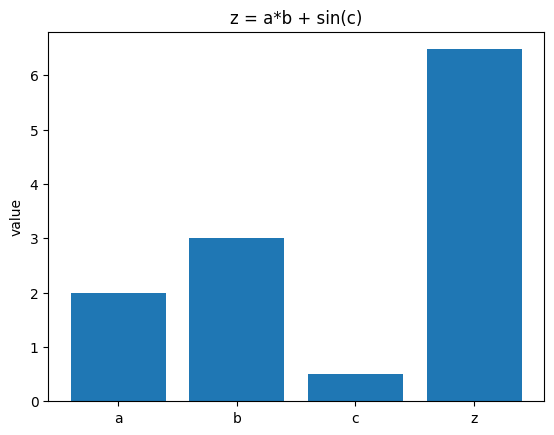

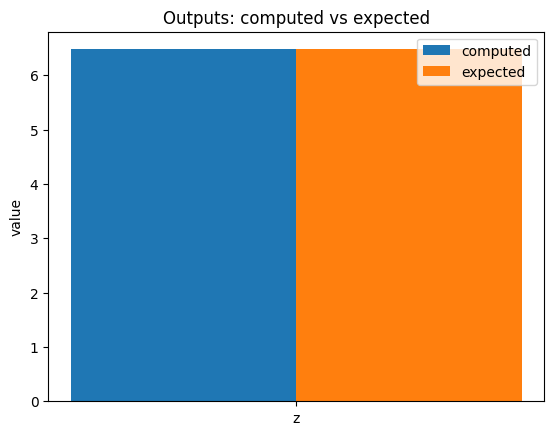

In [25]:
expected = {"z": 2.0 * 3.0 + np.sin(0.5)}
plot_single_eval(
    sim.state,
    inputs=("a", "b", "c"),
    outputs=("z",),
    expected=expected,
    title="z = a*b + sin(c)"
)


## 2. Time-Driven Expressions with `Tick`

So far, `MathExpressionStep` behaved like a pure function:
it mapped inputs to outputs once, without time.

In this section, we introduce a minimal `Tick` process to advance a time variable `t`.
This allows expressions to depend on time and generate **entire signal trajectories**,
while still keeping all math inside a single declarative Step.

Key ideas introduced here:

- A `Process` (`Tick`) advances time
- Expressions may reference `t` directly
- `MathExpressionStep` computes new values instantaneously at each tick
- The emitter records a time series of results

Importantly, **no additional Processes are needed** to generate dynamics —
time alone is enough.


In [26]:
# --- Time-driven expressions with Tick ---
sim = Composite(
    {
        "state": {
            # time
            "t": 0.0,

            # outputs (initialized, overwritten each tick)
            "a": 0.0,
            "b": 0.0,
            "z": 0.0,

            # Tick advances time
            "tick": {
                "_type": "process",
                "address": TICK_ADDR,
                "interval": 0.1,
                "inputs": {"t": ["t"]},
                "outputs": {"t": ["t"]},
            },

            # Declarative math driven by time
            "math": {
                "_type": "step",
                "address": MATH_ADDR,
                "config": {
                    "expressions": [
                        {"out": "a", "expr": "2.0 + sin(2*pi*0.5*t)"},
                        {"out": "b", "expr": "1.5 + cos(2*pi*0.2*t)"},
                        {"out": "z", "expr": "a * b"},
                    ],
                    "params": {"pi": float(np.pi)},
                    "functions": "numpy",
                    "debug": False,
                },
                "inputs": {"t": ["t"]},
                "outputs": {
                    "a": ["a"],
                    "b": ["b"],
                    "z": ["z"],
                },
            },

            # Record a time series
            "emitter": emitter_from_wires(
                {
                    "t": ["t"],
                    "a": ["a"],
                    "b": ["b"],
                    "z": ["z"],
                }
            ),
        }
    },
    core=core,
)

sim.run(10.0)
records = sim.state["emitter"]["instance"].query()

print("n records:", len(records))
print("first record:", records[0])
print("last record :", records[-1])



[MathExpressionStep] initialize()
  outputs declared: ['a', 'b', 'z']
  params: {'pi': 3.141592653589793}
  inferred input ports: ['t']
  dependency order: ['a', 'b', 'z']
   - a = 2.0 + sin(2*pi*0.5*t)
     depends on outputs: []
     needs symbols     : ['t']
   - b = 1.5 + cos(2*pi*0.2*t)
     depends on outputs: []
     needs symbols     : ['t']
   - z = a * b
     depends on outputs: ['a', 'b']
     needs symbols     : ['a', 'b']
[MathExpressionStep] initialize complete

n records: 101
first record: {'t': 0.0, 'a': 2.0, 'b': 2.5, 'z': 5.0}
last record : {'t': 9.99999999999998, 'a': 1.9999999999999383, 'b': 2.5, 'z': 4.9999999999998455}


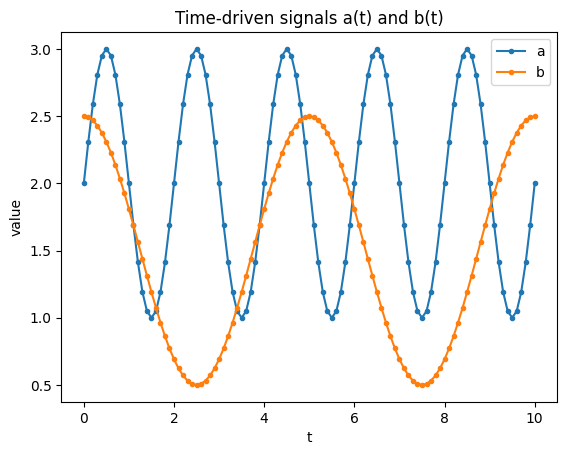

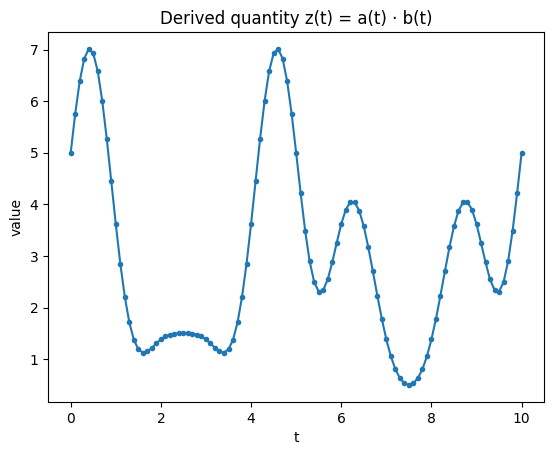

In [27]:
# Plot generated signals
plot_timeseries(
    records,
    ["a", "b"],
    title="Time-driven signals a(t) and b(t)",
    ylabel="value"
)

# Plot derived interaction
plot_timeseries(
    records,
    ["z"],
    title="Derived quantity z(t) = a(t) · b(t)",
    ylabel="value",
    legend=False
)


## 3. Multi-Stage Pipelines: Dependencies, Intermediates, and Auto-Ordering

In realistic models, outputs are rarely computed in a single step. More often, we build
a **pipeline** of intermediate quantities:

- generate signals from time (`a(t)`, `b(t)`, `k(t)`)
- combine them into an interaction term (`pre = a·b`)
- apply a nonlinear transform (`z = tanh(pre)`)
- normalize by a time-varying “knob” (`w = z / (1 + k)`)
- compute a final “score” that blends multiple features

This section shows two key features of `MathExpressionStep`:

1. **Intermediate variables are first-class outputs**
   - if you declare them as `out`, they become state fields and can be emitted/visualized.

2. **Expressions are evaluated in dependency order**
   - you can list them in any order; the Step will topologically sort the dependency graph.

We will intentionally provide the expressions in a scrambled order to prove that the
computed results still follow the correct dependency chain.


In [28]:
# --- Dependency-driven pipeline ---
sim = Composite(
    {"state": {
        "t": 0.0,

        # pipeline outputs (initialized, overwritten each tick)
        "a": 0.0,
        "b": 0.0,
        "k": 0.0,
        "pre": 0.0,
        "z": 0.0,
        "w": 0.0,
        "rect": 0.0,
        "score": 0.0,

        "tick": {
            "_type": "process",
            "address": TICK_ADDR,
            "interval": 0.1,
            "inputs": {"t": ["t"]},
            "outputs": {"t": ["t"]},
        },

        "math": {
            "_type": "step",
            "address": MATH_ADDR,
            "config": {
                # SCRAMBLED LIST: the Step will compute dependency order automatically
                "expressions": [
                    # downstream first:
                    {"out": "score", "expr": "0.65*w + 0.35*rect - 0.10*k"},
                    {"out": "rect",  "expr": "log(1 + pre**2)"},
                    {"out": "w",     "expr": "z / (1 + k)"},
                    {"out": "z",     "expr": "tanh(pre + 0.4*sin(2*pi*0.06*t))"},
                    {"out": "pre",   "expr": "a*b"},

                    # upstream signals last:
                    {"out": "k",     "expr": "0.8 + 0.6*(1 + sin(2*pi*0.03*t + 0.2))"},
                    {"out": "b",     "expr": "1.5 + 0.9*cos(2*pi*0.11*t)"},
                    {"out": "a",     "expr": "2.0 + 1.1*sin(2*pi*0.17*t + 0.3)"},
                ],
                "params": {"pi": float(np.pi)},
                "functions": "numpy",
                "debug": True,  # prints inferred inputs + dependency order
            },
            "inputs": {"t": ["t"]},
            "outputs": {
                "a": ["a"],
                "b": ["b"],
                "k": ["k"],
                "pre": ["pre"],
                "z": ["z"],
                "w": ["w"],
                "rect": ["rect"],
                "score": ["score"],
            },
        },

        "emitter": emitter_from_wires({
            "t": ["t"],
            "a": ["a"],
            "b": ["b"],
            "k": ["k"],
            "pre": ["pre"],
            "z": ["z"],
            "w": ["w"],
            "rect": ["rect"],
            "score": ["score"],
        }),
    }},
    core=core
)

sim.run(25.0)
records = sim.state["emitter"]["instance"].query()

print("n records:", len(records))
print("first:", records[0])
print("last :", records[-1])



[MathExpressionStep] initialize()
  outputs declared: ['score', 'rect', 'w', 'z', 'pre', 'k', 'b', 'a']
  params: {'pi': 3.141592653589793}
  inferred input ports: ['t']
  dependency order: ['a', 'b', 'k', 'pre', 'rect', 'z', 'w', 'score']
   - a = 2.0 + 1.1*sin(2*pi*0.17*t + 0.3)
     depends on outputs: []
     needs symbols     : ['t']
   - b = 1.5 + 0.9*cos(2*pi*0.11*t)
     depends on outputs: []
     needs symbols     : ['t']
   - k = 0.8 + 0.6*(1 + sin(2*pi*0.03*t + 0.2))
     depends on outputs: []
     needs symbols     : ['t']
   - pre = a*b
     depends on outputs: ['a', 'b']
     needs symbols     : ['a', 'b']
   - rect = log(1 + pre**2)
     depends on outputs: ['pre']
     needs symbols     : ['pre']
   - z = tanh(pre + 0.4*sin(2*pi*0.06*t))
     depends on outputs: ['pre']
     needs symbols     : ['pre', 't']
   - w = z / (1 + k)
     depends on outputs: ['k', 'z']
     needs symbols     : ['k', 'z']
   - score = 0.65*w + 0.35*rect - 0.10*k
     depends on outputs: ['k

### Plotting the pipeline

We visualize the flow of computation through the model:

`(a, b) → pre → z → w → score`

- `pre` captures the raw interaction between signals `a` and `b`
- `z = tanh(·)` applies a **saturating nonlinearity**, so `z(t)` is bounded and
  appears flat near its extremes
- `w = z / (1 + k)` applies a **time-varying normalization**, reducing the amplitude
  of `z` as the gain `k(t)` increases

The feature `rect(t) = log(1 + pre²)` measures the **magnitude** of the interaction
(independent of sign), while the final `score(t)` combines this magnitude with the
normalized signal and a penalty from `k(t)`.

As a result, `rect(t)` shows large positive peaks, while `score(t)` follows the same
structure but is smoother and intentionally smaller in scale.

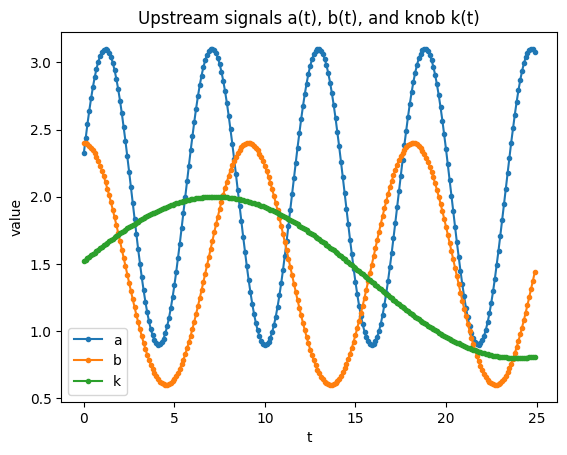

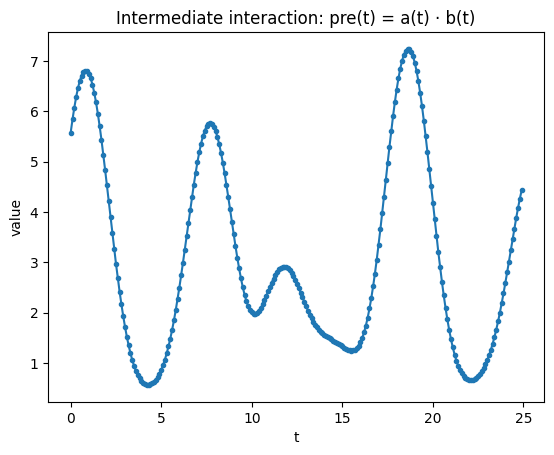

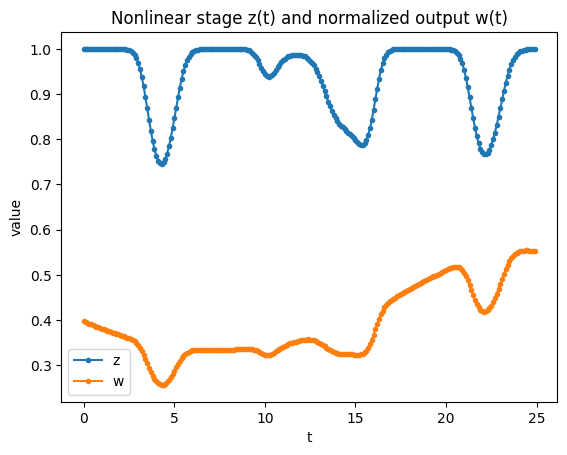

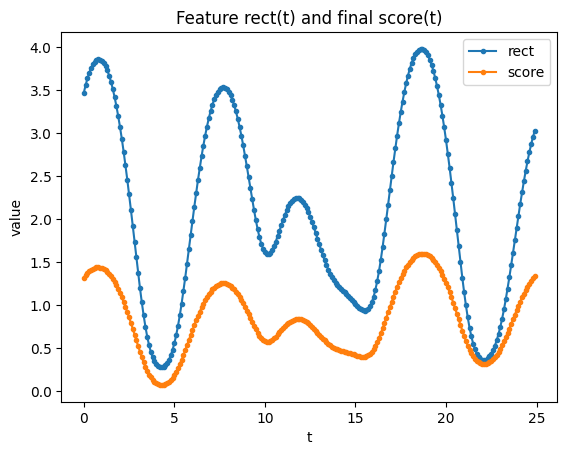

In [29]:
# Upstream signals
plot_timeseries(
    records,
    ["a", "b", "k"],
    title="Upstream signals a(t), b(t), and knob k(t)",
    ylabel="value"
)

# Intermediate interaction
plot_timeseries(
    records,
    ["pre"],
    title="Intermediate interaction: pre(t) = a(t) · b(t)",
    ylabel="value",
    legend=False
)

# Nonlinear transform and normalized output
plot_timeseries(
    records,
    ["z", "w"],
    title="Nonlinear stage z(t) and normalized output w(t)",
    ylabel="value"
)

# Rectified magnitude vs final score
plot_timeseries(
    records,
    ["rect", "score"],
    title="Feature rect(t) and final score(t)",
    ylabel="value"
)


## 4. From Continuous Signals to Events

So far, we have used `MathExpressionStep` to generate and transform continuous signals.
In many models, however, we ultimately care about **events** or **decisions**:
moments when a signal crosses a threshold, activates a response, or triggers downstream logic.

In this final example, we show that the same declarative math step can be used to:

- detect threshold-crossing events,
- convert continuous signals into discrete indicators,
- and gate downstream quantities based on those events.

Importantly, this requires **no new Processes** and **no custom Python logic** —
only additional expressions.

This pattern is useful for:
- event detection,
- feature thresholding,
- control logic,
- and bridging continuous dynamics with discrete decisions.


In [30]:
# --- Event detection and gating using MathExpressionStep ---
sim = Composite(
    {"state": {
        "t": 0.0,

        # upstream signals and features
        "a": 0.0,
        "b": 0.0,
        "k": 0.0,
        "pre": 0.0,
        "z": 0.0,
        "w": 0.0,
        "rect": 0.0,
        "score": 0.0,

        # new event-related outputs
        "event": 0.0,
        "gated_score": 0.0,

        "tick": {
            "_type": "process",
            "address": TICK_ADDR,
            "interval": 0.1,
            "inputs": {"t": ["t"]},
            "outputs": {"t": ["t"]},
        },

        "math": {
            "_type": "step",
            "address": MATH_ADDR,
            "config": {
                # Expressions intentionally include logic + math
                "expressions": [
                    # final stage first (scrambled on purpose)
                    {"out": "gated_score", "expr": "event * score"},
                    {"out": "event", "expr": "where(z > 0.9, 1.0, 0.0)"},  # event = 1.0 when z > 0.9, event = 0.0 otherwise

                    # score pipeline
                    {"out": "score", "expr": "0.7*w + 0.3*rect - 0.15*k"},
                    {"out": "rect", "expr": "log(1 + pre**2)"},
                    {"out": "w", "expr": "z / (1 + k)"},
                    {"out": "z", "expr": "tanh(pre + 0.4*sin(2*pi*0.06*t))"},
                    {"out": "pre", "expr": "a*b"},

                    # upstream signals
                    {"out": "k", "expr": "0.8 + 0.6*(1 + sin(2*pi*0.03*t + 0.2))"},
                    {"out": "b", "expr": "1.5 + 0.9*cos(2*pi*0.11*t)"},
                    {"out": "a", "expr": "2.0 + 1.1*sin(2*pi*0.17*t + 0.3)"},
                ],
                "params": {"pi": float(np.pi)},
                "functions": "numpy",
                "debug": False,
            },
            "inputs": {"t": ["t"]},
            "outputs": {
                "a": ["a"],
                "b": ["b"],
                "k": ["k"],
                "pre": ["pre"],
                "z": ["z"],
                "w": ["w"],
                "rect": ["rect"],
                "score": ["score"],
                "event": ["event"],
                "gated_score": ["gated_score"],
            },
        },

        "emitter": emitter_from_wires({
            "t": ["t"],
            "z": ["z"],
            "score": ["score"],
            "event": ["event"],
            "gated_score": ["gated_score"],
        }),
    }},
    core=core
)

sim.run(25.0)
records = sim.state["emitter"]["instance"].query()

print("n records:", len(records))
print("first:", records[0])
print("last :", records[-1])



[MathExpressionStep] initialize()
  outputs declared: ['gated_score', 'event', 'score', 'rect', 'w', 'z', 'pre', 'k', 'b', 'a']
  params: {'pi': 3.141592653589793}
  inferred input ports: ['t']
  dependency order: ['a', 'b', 'k', 'pre', 'rect', 'z', 'event', 'w', 'score', 'gated_score']
   - a = 2.0 + 1.1*sin(2*pi*0.17*t + 0.3)
     depends on outputs: []
     needs symbols     : ['t']
   - b = 1.5 + 0.9*cos(2*pi*0.11*t)
     depends on outputs: []
     needs symbols     : ['t']
   - k = 0.8 + 0.6*(1 + sin(2*pi*0.03*t + 0.2))
     depends on outputs: []
     needs symbols     : ['t']
   - pre = a*b
     depends on outputs: ['a', 'b']
     needs symbols     : ['a', 'b']
   - rect = log(1 + pre**2)
     depends on outputs: ['pre']
     needs symbols     : ['pre']
   - z = tanh(pre + 0.4*sin(2*pi*0.06*t))
     depends on outputs: ['pre']
     needs symbols     : ['pre', 't']
   - event = where(z > 0.9, 1.0, 0.0)
     depends on outputs: ['z']
     needs symbols     : ['z']
   - w = z / (

### Plotting events and gated outputs

We now visualize how a **continuous signal** gives rise to **discrete events**,
and how those events can control downstream quantities.

#### What to notice

- `event(t)` switches between 0 and 1 when `z(t)` crosses the threshold (`z > 0.9`)
- The event signal is **discrete**, even though it is computed from continuous inputs
- `gated_score(t)` is zero most of the time and only becomes active during events

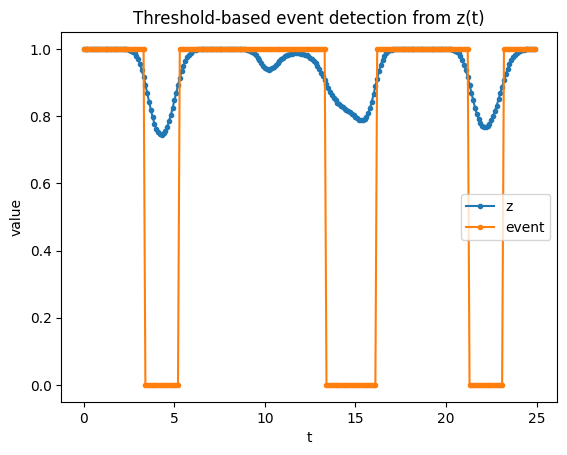

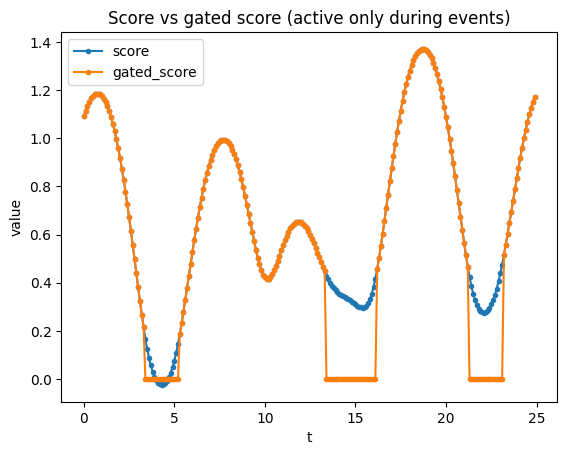

In [31]:
# Continuous signal and detected events
plot_timeseries(
    records,
    ["z", "event"],
    title="Threshold-based event detection from z(t)",
    ylabel="value"
)

# Original score vs gated score
plot_timeseries(
    records,
    ["score", "gated_score"],
    title="Score vs gated score (active only during events)",
    ylabel="value"
)